In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import cross_entropy
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pytorch_lightning as pl

c:\Users\rjk217\Miniconda3\envs\guidestar\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Load and flatten
data_path = Path("./Dataset/cells-raman-spectra/dataset_i/")
datasets = list(data_path.rglob("*.csv"))

x_data_raw = []  # Input data, 100cm^-1, 101cm^-1, ..., 2080cm^-1
y_data_raw = []  # Output label

for file in datasets:
    data = np.loadtxt(file, comments='#', delimiter=',')  # size (54, 2090)
    x_data_raw.append(data)

    for row in data:
        y_data_raw.append(file.parent.stem.split("-")[0])

In [3]:
x_data = np.concatenate(x_data_raw, axis=0)
y_data = np.array(y_data_raw)

In [4]:
input_shape = x_data[-1].size
print(input_shape)

2090


In [5]:
classification_list = sorted(set(y_data))
print(classification_list)

['A', 'DMEM', 'G', 'HF', 'MEL', 'ZAM']


In [6]:
from icecream import ic


In [7]:
def create_label_encoder(labels):
    from functools import singledispatch
    unique_labels = sorted(set(labels))
    unique_labels = [unique_label.upper() for unique_label in unique_labels]
    num_classes = len(unique_labels)

    # Two way dictionary hack
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    int_to_label = {i: label for label, i in label_to_int.items()}

    identity_matrix = np.eye(num_classes)

    @singledispatch
    def one_hot_encoder(y):
        raise NotImplementedError("Unsupported input type")

    @one_hot_encoder.register(list)
    @one_hot_encoder.register(np.ndarray)
    def _one_hot_list_encoder(y):
        encoded_labels = [label_to_int[label] for label in y]
        one_hot_labels = identity_matrix[encoded_labels]
        return one_hot_labels

    @one_hot_encoder.register(int)
    def _(y):
        if y < 0 or y >= num_classes:
            raise ValueError(f"y is out of range for {num_classes} classes")
        one_hot_label = identity_matrix[y]
        return one_hot_label

    @one_hot_encoder.register(str)
    def _one_hot_str_encoder(y):
        # Sanitize
        y = y.upper()
        if y not in unique_labels:
            raise ValueError(f"{y} not in labels")

        # Assuming a single string label
        encoded_label = label_to_int[y]
        one_hot_label = identity_matrix[encoded_label]
        return one_hot_label

    @singledispatch
    def one_hot_decoder(encoded_labels):
        raise NotImplementedError("Unsupported input type")

    @one_hot_decoder.register(torch.Tensor)
    def _one_hot_torch_decoder(encoded_labels):
        return one_hot_decoder(encoded_labels.numpy())

    @one_hot_decoder.register(np.ndarray)
    def _one_hot_np_decoder(encoded_labels):
        if encoded_labels.ndim > 2:
            decoded_labels = [int_to_label[i]
                              for i in np.argmax(encoded_labels, axis=-1)]
        else:
            decoded_labels = int_to_label[np.argmax(encoded_labels, axis=-1)]
        return decoded_labels

    return one_hot_encoder, one_hot_decoder, num_classes


label_encoder, label_decoder, num_classes = create_label_encoder(
    classification_list)
y_data_encoded = label_encoder(y_data)

print("Number of Unique Classes:", num_classes)

Number of Unique Classes: 6


In [8]:
ic(label_encoder(5))
ic(label_encoder('A'))

encoded_a = label_encoder('A')
ic(encoded_a)

ic(label_decoder(encoded_a))


ic| label_encoder(5): array([0., 0., 0., 0., 0., 1.])
ic| label_encoder('A'): array([1., 0., 0., 0., 0., 0.])
ic| encoded_a: array([1., 0., 0., 0., 0., 0.])
ic| label_decoder(encoded_a): 'A'


'A'

In [9]:
def standard_scaler(x):
    mean_ = np.mean(x, axis=-1, keepdims=True)
    scale_ = np.std(x, axis=-1, keepdims=True)
    standardized_data = (x - mean_) / scale_
    return standardized_data


x_data = standard_scaler(x_data)

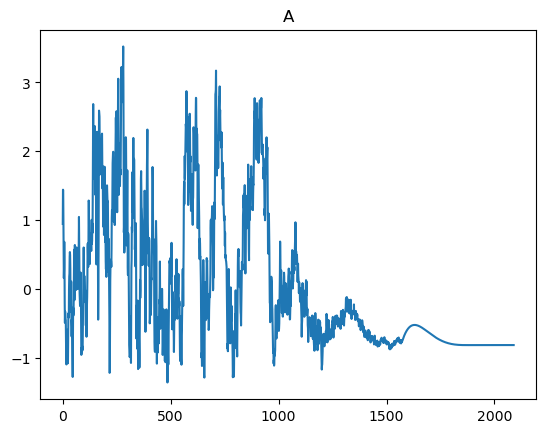

In [10]:
from matplotlib import pyplot as plt
idx = 20
plt.plot(x_data[idx])
plt.title(y_data_raw[idx])
plt.show()

In [11]:
from torch.utils.data import Dataset, DataLoader, random_split


class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_data[idx]).float()
        y = torch.from_numpy(self.y_data[idx]).float()
        return x, y


# Convert to PyTorch DataLoader
dataset = CustomDataset(x_data, y_data_encoded)

# Split into train, validation, and test sets
train_length = int(len(dataset)*0.8)
val_length = int(len(dataset)*0.1)
test_length = len(dataset) - (train_length + val_length)
lengths = [train_length, val_length, test_length]
train_dataset, val_dataset, test_dataset = random_split(
    dataset, lengths, generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# Shuffled on creation
val_loader = DataLoader(val_dataset, batch_size=128,
                        shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128,
                         shuffle=False)

In [12]:
import torch.nn.functional as F
import torchmetrics


class LightningClassifier(pl.LightningModule):
    def __init__(self, input_size, num_classes):
        super().__init__()

        # Model
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)

        # self.accuracy = torchmetrics.classification.Accuracy(
        #     task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)

        # self.accuracy(y_hat, y)
        # self.log('train_acc_step', self.accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

    # def on_train_epoch_end(self):
    #     # log epoch metric
    #     self.log('train_acc_epoch', self.accuracy)


# PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=50)
lightning_model = LightningClassifier(input_shape, num_classes)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\rjk217\Miniconda3\envs\guidestar\lib\site-packages\pytorch_lightning\trainer\trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [13]:
# Train the model
trainer.fit(lightning_model, train_loader, val_loader, )


  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 535 K 
1 | fc2  | Linear | 16.4 K
2 | fc3  | Linear | 2.1 K 
3 | fc4  | Linear | 198   
--------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.216     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\rjk217\Miniconda3\envs\guidestar\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\rjk217\Miniconda3\envs\guidestar\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\rjk217\Miniconda3\envs\guidestar\lib\site-packages\pytorch_lightning\trainer\trainer.py:1892: PossibleUserWarning: The number of training batches (13) is smaller than the 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [14]:
x_test, y_test = test_loader.dataset[0]
label_decoder(y_test.numpy())

'A'

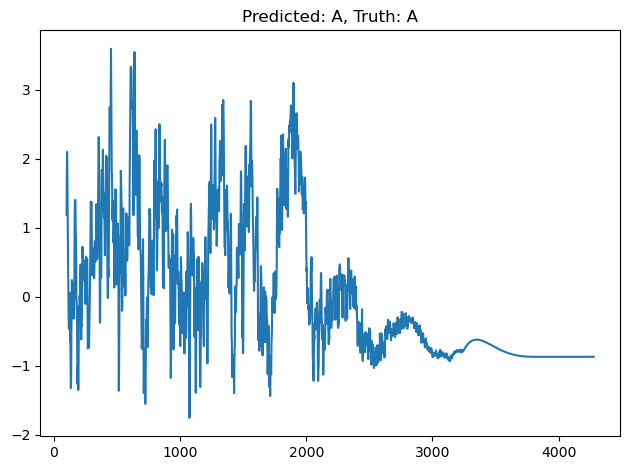

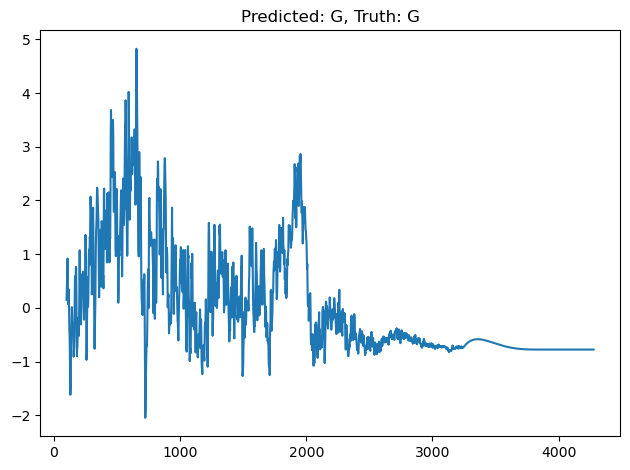

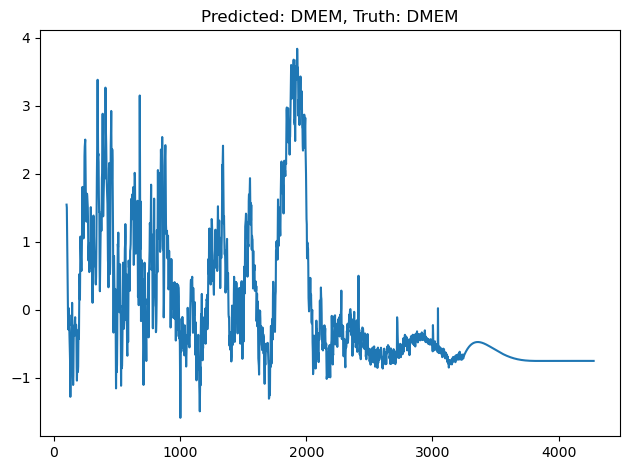

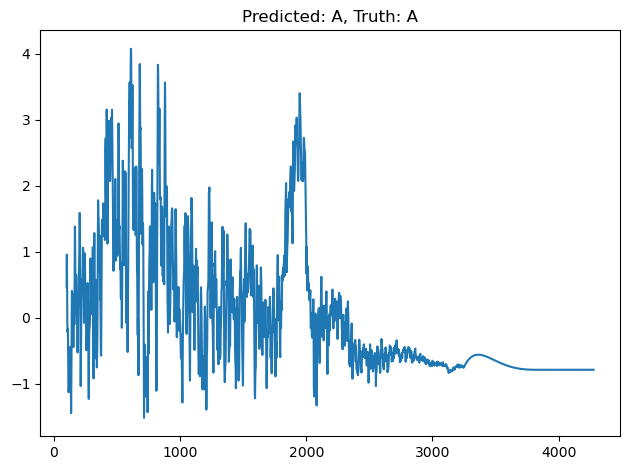

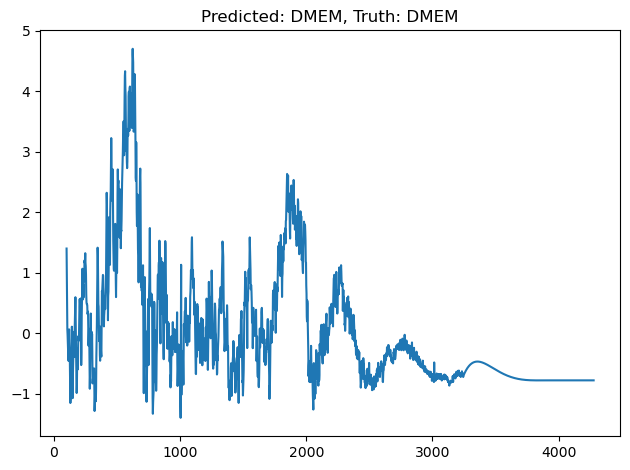

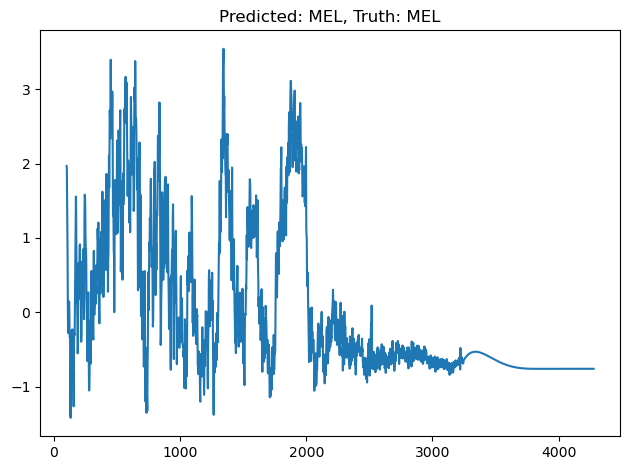

In [32]:
font_dict = {'color': 'black'}
i = 0
for x_test, y_test in test_loader.dataset:
    plt.plot(np.linspace(100, 4278, 2090), x_test)
    with torch.no_grad():
        y_pred = label_decoder(lightning_model(x_test).numpy())
    true_value = label_decoder(y_test)
    font_dict['color'] = "black" if y_pred == true_value else 'red'
    plt.title(
        f"Predicted: {y_pred}, Truth: {true_value}", fontdict=font_dict)
    plt.tight_layout()
    plt.show()

    if i > 4:
        break
    i+=1
    